In [ ]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import gc
from tqdm import tqdm
import time
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

import pdb

import wandb

# Defining global parameters

In [ ]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": get_available_device(),
    'labels': ['unable_to_assess', 'not_close_match','close_match', 'near_exact_match', 'exact_match'], # 'unable_to_assess', 'not_close_match','close_match', 'near_exact_match', 'exact_match'
    'FP': 'grover', # 'fp', 'molformer', 'ECFP', 'grover'
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=CONFIG['seed'])

# Read the data that has duplicates REMOVED
## Validation set of 20% of the size

In [ ]:
train_df = pd.read_pickle('../data/train_split_remove_duplicates_all_embeddings.pkl')
valid_df = pd.read_pickle('../data/valid_split_remove_duplicates_all_embeddings.pkl')

In [ ]:
if CONFIG['FP'] == 'ECFP':
    CONFIG['input_size'] = 2048
elif CONFIG['FP'] == 'molformer':
    CONFIG['input_size'] = 768
elif CONFIG['FP'] == 'fp':
    CONFIG['input_size'] = 2215
elif CONFIG['FP'] == 'grover':
    CONFIG['input_size'] = 5000


## Wrapping in Pytorch Dataset

In [ ]:
class EnvedaDataset(Dataset):
    def __init__(self, CONFIG, dataframe, labels = []):
        """
        Args:
            dataframe (pd.DataFrame): A DataFrame containing 'ground_truth_embeddings', 
                                       'predicted_embeddings', and output columns.
        """
        self.dataframe = dataframe
        
        if CONFIG['FP'] == 'molformer':
            # Convert Molformer embeddings to tensors
            self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)
            self.predicted_embeddings = torch.tensor(dataframe['predicted_embeddings'].tolist(), dtype=torch.float32)
    
        # fingerprints
        elif CONFIG['FP'] == 'ECFP':
            self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_ECFP'].tolist(), dtype=torch.float32)
            self.predicted_embeddings = torch.tensor(dataframe['predicted_ECFP'].tolist(), dtype=torch.float32)
        elif CONFIG['FP'] == 'fp':
            self.ground_truth_embeddings = dataframe['ground_truth_fp']
            self.predicted_embeddings = dataframe['predicted_fp']

        elif CONFIG['FP'] == 'grover':
            self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_grover_fp'].tolist(), dtype=torch.float32)
            self.predicted_embeddings = torch.tensor(dataframe['predicted_grover_fp'].tolist(), dtype=torch.float32)
    
        
        self.labels_text = labels
        # Convert labels to tensor
        self.labels = torch.tensor(dataframe[labels].values, dtype=torch.float32)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        if CONFIG['FP'] == 'molformer':
            return self.ground_truth_embeddings[idx].squeeze(0), self.predicted_embeddings[idx].squeeze(0), self.labels[idx]
        elif CONFIG['FP'] == 'fp':
            return self.ground_truth_embeddings.iloc[idx].squeeze(0), self.predicted_embeddings.iloc[idx].squeeze(0), self.labels[idx]
        elif CONFIG['FP'] == 'ECFP':
            return self.ground_truth_embeddings[idx], self.predicted_embeddings[idx], self.labels[idx]
        elif CONFIG['FP'] == 'grover':
            return self.ground_truth_embeddings[idx].squeeze(0), self.predicted_embeddings[idx].squeeze(0), self.labels[idx]


In [ ]:
trainset = EnvedaDataset(CONFIG, dataframe=train_df, labels=CONFIG['labels'])
validset = EnvedaDataset(CONFIG, dataframe=valid_df, labels=CONFIG['labels'])

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_6815/2166135352.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)


## Wrapping in Pytorch DataLoader

In [ ]:
trainloader, validloader = DataLoader(trainset, batch_size=CONFIG['train_batch_size']), \
                           DataLoader(validset, batch_size=CONFIG['valid_batch_size'])

In [ ]:
gt, pred, labels = next(iter(trainloader))
print(gt.shape, pred.shape, labels.shape)


torch.Size([16, 768]) torch.Size([16, 768]) torch.Size([16, 5])


# Defining neural network

In [ ]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim=768, output_dim=4):
        super(SiameseNetwork, self).__init__()

        self.fc = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2))

        self.fc5 = nn.Linear(128, output_dim)

        #self.fc5 = nn.Linear(16 * 2, output_dim)  # Output layer for similarity judgements

    def forward_one(self, x):
        return self.fc(x)

    def forward(self, input1, input2):
        out1 = self.forward_one(input1)
        out2 = self.forward_one(input2)
        # pdb.set_trace()
        # Combine both outputs by concatenation
        # combined = torch.concat((out1, out2), dim=1) # concatenate embeddings
        combined = torch.sub(out1, out2)  # maybe torch.abs(out1 - out2)
        output = self.fc5(combined)                  # Outputs raw logits
        return output
    
# model = SiameseNetwork()
# model(gt, pred)

# Training and validation regime

## Training with mixed precision, gradient accumulation, learning with scheduler
## Validation logging loss, AUROC, and F1 metrics

In [ ]:
def train_one_epoch(model, optimizer, criterion, scheduler, dataloader, epoch=CONFIG['epochs']):
    model.train()
    
    scaler = GradScaler()
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    running_f1 = 0.0
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = gt.shape[0]

        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
            
        # Backward pass with scaling
        scaler.scale(loss).backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            # Step the optimizer
            scaler.step(optimizer)

            # Update the scale for next iteration
            scaler.update()
            # optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        # pdb.set_trace()
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        # pdb.set_trace()
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc, Train_F1=epoch_f1,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

@torch.no_grad()
def valid_one_epoch(model, dataloader, criterion, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_f1 = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = gt.shape[0]
        
        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
        
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        
        auroc = average_precision_score(targets.cpu().numpy(), probabilities, average='weighted')
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                        Valid_F1=epoch_f1,
                        )   
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

## Initializing components
1. Model
2. AdamW optimizer
3. Cosine annealing scheduler
4. Weighted cross entropy loss to handle class imbalance

In [ ]:
model = SiameseNetwork(input_dim=CONFIG['input_size'], output_dim=len(CONFIG['labels'])).to(CONFIG['device'])
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])

class_distribution = {'unable_to_assess': 10,
                      'not_close_match': 109, 
                      'close_match': 125, 
                      'near_exact_match': 66, 
                      'exact_match': 12,
                      'good_enough_for_prioritization': 224}

# Calculate class weights
total_samples = sum(class_distribution.values())
class_weights = {label: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()}

# Convert weights to a tensor
weights = torch.tensor([class_weights['unable_to_assess'],
                        class_weights['not_close_match'],
                        class_weights['close_match'],
                        class_weights['near_exact_match'],
                        class_weights['exact_match']], dtype=torch.float32).to(CONFIG['device'])

# find the indeces of keys in class_distribution in CONFIG['labels']
weights = torch.tensor([class_weights[c] for c in CONFIG['labels']], dtype=torch.float32).to(CONFIG['device'])

# Modify the loss function in your training loop
criterion = nn.CrossEntropyLoss(weight=weights)



In [ ]:
# train_one_epoch(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, dataloader=trainloader)
# valid_one_epoch(model=model, dataloader=trainloader, criterion=criterion, epoch=CONFIG['epochs'])

## Putting all together into training code
Training code includes:
1. Early stopping
2. Saving best model weights according to supplied name
3. Original code adapted from Kaggle

In [ ]:

def run_training(model, optimizer, scheduler, criterion, num_epochs, train_loader, valid_loader, name):

    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    directory = '../results/' # for saving models/results
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_f1 = -np.inf
    best_valid_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc, train_epoch_f1 = train_one_epoch(model=model, optimizer=optimizer, scheduler=scheduler, 
                                           criterion=criterion, dataloader=train_loader, 
                                           epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, val_epoch_f1 = valid_one_epoch(model=model, dataloader=valid_loader, criterion=criterion, 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['Valid F1'].append(val_epoch_f1)
        history['lr'].append( scheduler.get_lr()[0] )

        wandb.log({
            "Train Loss": train_epoch_loss,
            "Valid Loss": val_epoch_loss,
            "Train AUROC": train_epoch_auroc,
            "Valid AUROC": val_epoch_auroc,
            "Valid F1": val_epoch_f1,
            "lr": scheduler.get_lr()[0]
        })

        if val_epoch_loss <= best_valid_loss:
            print(f"Validation Loss Improved ({best_valid_loss} ---> {val_epoch_loss})")
            best_valid_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = directory + f"best_VAL_LOSS_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
        
        if best_epoch_f1 <= val_epoch_f1:
            print(f"Validation F1 Improved ({best_epoch_f1} ---> {val_epoch_f1})")
            best_epoch_f1 = val_epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = directory + f"best_F1_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best F1: {:.4f}".format(best_epoch_f1))
    print("Best Loss: {:.4f}".format(best_valid_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# Runs

In [ ]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anwangxuelong. Use `wandb login --relogin` to force relogin


True

In [ ]:
CONFIG['dropout'] = 0.2
CONFIG['epochs'] = 200

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="siamese_network",
    name="multiclass_siamese_grover_sub_drop_awx",

    # track hyperparameters and run metadata
    config=CONFIG
)

# Track gradients and log the model architecture
wandb.watch(model, log="all")

[]

In [ ]:
model, history = run_training(model=model, optimizer=optimizer, 
                              scheduler=scheduler, criterion=criterion, 
                              num_epochs=CONFIG['epochs'], train_loader=trainloader, valid_loader=validloader, 
                              name='siamese_multiclass_sub_grover')

wandb.finish()

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▍         | 1/22 [00:00<00:11,  1.82it/s, Epoch=1, LR=4.92e-5, Train_Auroc=0.203, Train_F1=0.0128, Train_Loss=1.69]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.

Validation Loss Improved (inf ---> 1.7779926495118574)
Model Saved
Validation F1 Improved (-inf ---> 0.00041440041440041447)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=2, LR=4.92e-5, Train_Auroc=0.534, Train_F1=0.0139, Train_Loss=1.66]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.7779926495118574 ---> 1.7776019248095425)
Model Saved
Validation F1 Improved (0.00041440041440041447 ---> 0.00041440041440041447)
Model Saved



/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=3, LR=4.28e-5, Train_Auroc=0.285, Train_F1=0.0128, Train_Loss=1.68]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-p

Validation Loss Improved (1.7776019248095425 ---> 1.7765667763623325)
Model Saved
Validation F1 Improved (0.00041440041440041447 ---> 0.00041440041440041447)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=4, LR=3.17e-5, Train_Auroc=0.415, Train_F1=0.0152, Train_Loss=1.67]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.7765667763623325 ---> 1.7758515856482766)
Model Saved
Validation F1 Improved (0.00041440041440041447 ---> 0.00041440041440041447)
Model Saved



/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=5, LR=1.88e-5, Train_Auroc=0.139, Train_F1=0.0119, Train_Loss=1.69]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-p

Validation Loss Improved (1.7758515856482766 ---> 1.7748554944992065)
Model Saved
Validation F1 Improved (0.00041440041440041447 ---> 0.00042087542087542086)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=6, LR=7.75e-6, Train_Auroc=0.279, Train_F1=0.0128, Train_Loss=1.67]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.7748554944992065 ---> 1.773253321647644)
Model Saved
Validation F1 Improved (0.00042087542087542086 ---> 0.00042087542087542086)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=7, LR=1.34e-6, Train_Auroc=0.599, Train_F1=0.0962, Train_Loss=1.65]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.773253321647644 ---> 1.7718585512854836)
Model Saved
Validation F1 Improved (0.00042087542087542086 ---> 0.00042087542087542086)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=8, LR=1.34e-6, Train_Auroc=0.354, Train_F1=0.0139, Train_Loss=1.66]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.7718585512854836 ---> 1.7700082605535334)
Model Saved
Validation F1 Improved (0.00042087542087542086 ---> 0.00042087542087542086)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=9, LR=7.75e-6, Train_Auroc=0.272, Train_F1=0.0152, Train_Loss=1.67]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.7700082605535334 ---> 1.7682580514387651)
Model Saved
Validation F1 Improved (0.00042087542087542086 ---> 0.00042087542087542086)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=10, LR=1.88e-5, Train_Auroc=0.269, Train_F1=0.0111, Train_Loss=1.68]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (1.7682580514387651 ---> 1.7657359838485718)
Model Saved
Validation F1 Improved (0.00042087542087542086 ---> 0.0004344520473552731)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=11, LR=3.17e-5, Train_Auroc=0.262, Train_F1=0.0152, Train_Loss=1.66]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (1.7657359838485718 ---> 1.7633738626133313)
Model Saved
Validation F1 Improved (0.0004344520473552731 ---> 0.0004489337822671156)
Model Saved



/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=12, LR=4.28e-5, Train_Auroc=0.305, Train_F1=0.0152, Train_Loss=1.68]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-

Validation Loss Improved (1.7633738626133313 ---> 1.761067737232555)
Model Saved
Validation F1 Improved (0.0004489337822671156 ---> 0.0004489337822671156)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=13, LR=4.92e-5, Train_Auroc=0.384, Train_F1=0.194, Train_Loss=1.68]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.761067737232555 ---> 1.7579272118481724)
Model Saved
Validation F1 Improved (0.0004489337822671156 ---> 0.0004644142575177058)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=14, LR=4.92e-5, Train_Auroc=0.397, Train_F1=0.0833, Train_Loss=1.68]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (1.7579272118481724 ---> 1.7541303743015637)
Model Saved
Validation F1 Improved (0.0004644142575177058 ---> 0.025815969020837173)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=15, LR=4.28e-5, Train_Auroc=0.435, Train_F1=0.0694, Train_Loss=1.65]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (1.7541303743015637 ---> 1.7492745897986672)
Model Saved
Validation F1 Improved (0.025815969020837173 ---> 0.02961199542726891)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=16, LR=3.17e-5, Train_Auroc=0.287, Train_F1=0.156, Train_Loss=1.64]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.7492745897986672 ---> 1.7418552853844382)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=17, LR=1.88e-5, Train_Auroc=0.218, Train_F1=0, Train_Loss=1.69]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User pr

Validation Loss Improved (1.7418552853844382 ---> 1.73401555148038)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=18, LR=7.75e-6, Train_Auroc=0.376, Train_F1=0.119, Train_Loss=1.6]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation Loss Improved (1.73401555148038 ---> 1.7206691395152698)
Model Saved
Validation F1 Improved (0.02961199542726891 ---> 0.09444529469781994)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=19, LR=1.34e-6, Train_Auroc=0.188, Train_F1=0.116, Train_Loss=1.67]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.7206691395152698 ---> 1.7066448710181497)
Model Saved
Validation F1 Improved (0.09444529469781994 ---> 0.11130704190651487)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=20, LR=1.34e-6, Train_Auroc=0.201, Train_F1=0.0119, Train_Loss=1.6]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.7066448710181497 ---> 1.6954843239350752)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=21, LR=7.75e-6, Train_Auroc=0.415, Train_F1=0.182, Train_Loss=1.57]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.6954843239350752 ---> 1.6812862916426226)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=22, LR=1.88e-5, Train_Auroc=0.5, Train_F1=0.348, Train_Loss=1.58]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packag

Validation Loss Improved (1.6812862916426226 ---> 1.6709989309310913)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=23, LR=3.17e-5, Train_Auroc=0.274, Train_F1=0.225, Train_Loss=1.66]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.6709989309310913 ---> 1.6573620601133867)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=24, LR=4.28e-5, Train_Auroc=0.311, Train_F1=0.368, Train_Loss=1.52]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.6573620601133867 ---> 1.6464601755142212)
Model Saved
Validation F1 Improved (0.11130704190651487 ---> 0.11879570138298728)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=25, LR=4.92e-5, Train_Auroc=0.262, Train_F1=0.265, Train_Loss=1.72]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.6464601755142212 ---> 1.6389270587400957)
Model Saved
Validation F1 Improved (0.11879570138298728 ---> 0.13366995658662326)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.479, Train_F1=0.213, Train_Loss=1.45]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.6389270587400957 ---> 1.6301283944736829)
Model Saved
Validation F1 Improved (0.13366995658662326 ---> 0.1491229029107817)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=27, LR=4.28e-5, Train_Auroc=0.399, Train_F1=0.248, Train_Loss=1.41]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.6301283944736829 ---> 1.6262418573552913)
Model Saved
Validation F1 Improved (0.1491229029107817 ---> 0.15071156497162702)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=28, LR=3.17e-5, Train_Auroc=0.344, Train_F1=0.0278, Train_Loss=1.43]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (1.6262418573552913 ---> 1.6150168830698186)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=29, LR=1.88e-5, Train_Auroc=0.315, Train_F1=0.15, Train_Loss=1.28]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation Loss Improved (1.6150168830698186 ---> 1.6032593792135066)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=30, LR=7.75e-6, Train_Auroc=0.337, Train_F1=0.44, Train_Loss=1.35]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation Loss Improved (1.6032593792135066 ---> 1.5977716879411177)
Model Saved
Validation F1 Improved (0.15071156497162702 ---> 0.155550353880143)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=31, LR=1.34e-6, Train_Auroc=0.257, Train_F1=0.104, Train_Loss=1.47]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.5977716879411177 ---> 1.5861685384403577)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=32, LR=1.34e-6, Train_Auroc=0.302, Train_F1=0.334, Train_Loss=1.41]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.5861685384403577 ---> 1.5759134400974621)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=33, LR=7.75e-6, Train_Auroc=0.221, Train_F1=0.172, Train_Loss=1.3]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User

Validation Loss Improved (1.5759134400974621 ---> 1.566669377413663)
Model Saved
Validation F1 Improved (0.155550353880143 ---> 0.1767179696472626)
Model Saved



/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=34, LR=1.88e-5, Train_Auroc=0.349, Train_F1=0.161, Train_Loss=1.26]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-p

Validation Loss Improved (1.566669377413663 ---> 1.5603486082770608)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=35, LR=3.17e-5, Train_Auroc=0.291, Train_F1=0.242, Train_Loss=1.12]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (1.5603486082770608 ---> 1.557291941209273)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=36, LR=4.28e-5, Train_Auroc=0.363, Train_F1=0.364, Train_Loss=1.17]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

Validation Loss Improved (1.557291941209273 ---> 1.551842917095531)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=37, LR=4.92e-5, Train_Auroc=0.403, Train_F1=0.45, Train_Loss=1.33]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=38, LR=4.92e-5, Train_Auroc=0.317, Train_F1=0.317, Train_Loss=1.28]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=39, LR=4.28e-5, Train_Auroc=0.576, Train_F1=0.361, Train_Loss=0.936]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

Validation F1 Improved (0.1767179696472626 ---> 0.1872373305706639)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=40, LR=3.17e-5, Train_Auroc=0.469, Train_F1=0.489, Train_Loss=1.03]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=41, LR=1.88e-5, Train_Auroc=0.419, Train_F1=0.429, Train_Loss=1.04]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=42, LR=7.75e-6, Train_Auroc=0.385, Train_F1=0.22, Train_Loss=0.978]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=43, LR=1.34e-6, Train_Auroc=0.515, Train_F1=0.435, Train_Loss=1.18]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation F1 Improved (0.1872373305706639 ---> 0.2029470996642714)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=44, LR=1.34e-6, Train_Auroc=0.386, Train_F1=0.472, Train_Loss=0.991]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation F1 Improved (0.2029470996642714 ---> 0.23129627271784134)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=45, LR=7.75e-6, Train_Auroc=0.421, Train_F1=0.22, Train_Loss=0.905]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=46, LR=1.88e-5, Train_Auroc=0.479, Train_F1=0.36, Train_Loss=0.911]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=47, LR=3.17e-5, Train_Auroc=0.517, Train_F1=0.43, Train_Loss=0.904]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=48, LR=4.28e-5, Train_Auroc=0.408, Train_F1=0.291, Train_Loss=0.974]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation F1 Improved (0.23129627271784134 ---> 0.2316693444620917)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=49, LR=4.92e-5, Train_Auroc=0.473, Train_F1=0.486, Train_Loss=0.918]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=50, LR=4.92e-5, Train_Auroc=0.631, Train_F1=0.41, Train_Loss=0.87]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=51, LR=4.28e-5, Train_Auroc=0.447, Train_F1=0.283, Train_Loss=0.883]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=52, LR=3.17e-5, Train_Auroc=0.646, Train_F1=0.633, Train_Loss=0.726]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=53, LR=1.88e-5, Train_Auroc=0.427, Train_F1=0.403, Train_Loss=0.827]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=54, LR=7.75e-6, Train_Auroc=0.466, Train_F1=0.317, Train_Loss=0.76]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=55, LR=1.34e-6, Train_Auroc=0.436, Train_F1=0.236, Train_Loss=0.785]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=56, LR=1.34e-6, Train_Auroc=0.5, Train_F1=0.528, Train_Loss=0.741]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=57, LR=7.75e-6, Train_Auroc=0.543, Train_F1=0.616, Train_Loss=0.674]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=58, LR=1.88e-5, Train_Auroc=0.44, Train_F1=0.242, Train_Loss=0.786]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=59, LR=3.17e-5, Train_Auroc=0.598, Train_F1=0.526, Train_Loss=0.716]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=60, LR=4.28e-5, Train_Auroc=0.552, Train_F1=0.494, Train_Loss=0.678]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=61, LR=4.92e-5, Train_Auroc=0.621, Train_F1=0.51, Train_Loss=0.778]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=62, LR=4.92e-5, Train_Auroc=0.467, Train_F1=0.225, Train_Loss=0.716]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=63, LR=4.28e-5, Train_Auroc=0.487, Train_F1=0.542, Train_Loss=0.71]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=64, LR=3.17e-5, Train_Auroc=0.492, Train_F1=0.369, Train_Loss=0.724]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=65, LR=1.88e-5, Train_Auroc=0.675, Train_F1=0.514, Train_Loss=0.636]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=66, LR=7.75e-6, Train_Auroc=0.398, Train_F1=0.361, Train_Loss=0.704]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=67, LR=1.34e-6, Train_Auroc=0.534, Train_F1=0.481, Train_Loss=0.625]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=68, LR=1.34e-6, Train_Auroc=0.472, Train_F1=0.306, Train_Loss=0.645]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=69, LR=7.75e-6, Train_Auroc=0.607, Train_F1=0.558, Train_Loss=0.568]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=70, LR=1.88e-5, Train_Auroc=0.71, Train_F1=0.562, Train_Loss=0.572]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=71, LR=3.17e-5, Train_Auroc=0.628, Train_F1=0.661, Train_Loss=0.536]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=72, LR=4.28e-5, Train_Auroc=0.648, Train_F1=0.458, Train_Loss=0.59]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=73, LR=4.92e-5, Train_Auroc=0.599, Train_F1=0.654, Train_Loss=0.545]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=74, LR=4.92e-5, Train_Auroc=0.588, Train_F1=0.375, Train_Loss=0.606]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=75, LR=4.28e-5, Train_Auroc=0.748, Train_F1=0.666, Train_Loss=0.64]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation F1 Improved (0.2316693444620917 ---> 0.23637480949733913)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=76, LR=3.17e-5, Train_Auroc=0.681, Train_F1=0.58, Train_Loss=0.495]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation F1 Improved (0.23637480949733913 ---> 0.23701971612050662)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=77, LR=1.88e-5, Train_Auroc=0.673, Train_F1=0.518, Train_Loss=0.475]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=78, LR=7.75e-6, Train_Auroc=0.723, Train_F1=0.667, Train_Loss=0.496]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=79, LR=1.34e-6, Train_Auroc=0.706, Train_F1=0.798, Train_Loss=0.464]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=80, LR=1.34e-6, Train_Auroc=0.699, Train_F1=0.655, Train_Loss=0.48]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=81, LR=7.75e-6, Train_Auroc=0.668, Train_F1=0.556, Train_Loss=0.487]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=82, LR=1.88e-5, Train_Auroc=0.753, Train_F1=0.51, Train_Loss=0.447]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

Validation F1 Improved (0.23701971612050662 ---> 0.2666583416583416)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=83, LR=3.17e-5, Train_Auroc=0.755, Train_F1=0.73, Train_Loss=0.426]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=84, LR=4.28e-5, Train_Auroc=0.7, Train_F1=0.798, Train_Loss=0.408]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=85, LR=4.92e-5, Train_Auroc=0.634, Train_F1=0.589, Train_Loss=0.46]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation F1 Improved (0.2666583416583416 ---> 0.28511715507748575)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=86, LR=4.92e-5, Train_Auroc=0.693, Train_F1=0.635, Train_Loss=0.459]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=87, LR=4.28e-5, Train_Auroc=0.744, Train_F1=0.64, Train_Loss=0.376]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=88, LR=3.17e-5, Train_Auroc=0.749, Train_F1=0.737, Train_Loss=0.395]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=89, LR=1.88e-5, Train_Auroc=0.74, Train_F1=0.757, Train_Loss=0.405]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation F1 Improved (0.28511715507748575 ---> 0.28511715507748575)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=90, LR=7.75e-6, Train_Auroc=0.731, Train_F1=0.74, Train_Loss=0.369]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=91, LR=1.34e-6, Train_Auroc=0.762, Train_F1=0.729, Train_Loss=0.32]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=92, LR=1.34e-6, Train_Auroc=0.737, Train_F1=0.721, Train_Loss=0.363]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=93, LR=7.75e-6, Train_Auroc=0.766, Train_F1=0.735, Train_Loss=0.358]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=94, LR=1.88e-5, Train_Auroc=0.769, Train_F1=0.749, Train_Loss=0.328]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=95, LR=3.17e-5, Train_Auroc=0.756, Train_F1=0.723, Train_Loss=0.294]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=96, LR=4.28e-5, Train_Auroc=0.751, Train_F1=0.709, Train_Loss=0.369]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=97, LR=4.92e-5, Train_Auroc=0.747, Train_F1=0.631, Train_Loss=0.334]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=98, LR=4.92e-5, Train_Auroc=0.761, Train_F1=0.729, Train_Loss=0.294]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=99, LR=4.28e-5, Train_Auroc=0.743, Train_F1=0.709, Train_Loss=0.269]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

Validation F1 Improved (0.28511715507748575 ---> 0.2905218154849889)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=100, LR=3.17e-5, Train_Auroc=0.769, Train_F1=0.865, Train_Loss=0.29]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=101, LR=1.88e-5, Train_Auroc=0.753, Train_F1=0.798, Train_Loss=0.279]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=102, LR=7.75e-6, Train_Auroc=0.74, Train_F1=0.738, Train_Loss=0.348]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=103, LR=1.34e-6, Train_Auroc=0.762, Train_F1=0.722, Train_Loss=0.307]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=104, LR=1.34e-6, Train_Auroc=0.772, Train_F1=0.821, Train_Loss=0.243]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pa

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=105, LR=7.75e-6, Train_Auroc=0.751, Train_F1=0.792, Train_Loss=0.235]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=106, LR=1.88e-5, Train_Auroc=0.761, Train_F1=0.765, Train_Loss=0.253]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pa

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=107, LR=3.17e-5, Train_Auroc=0.708, Train_F1=0.617, Train_Loss=0.298]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

Validation F1 Improved (0.2905218154849889 ---> 0.3055654574646578)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=108, LR=4.28e-5, Train_Auroc=0.753, Train_F1=0.789, Train_Loss=0.249]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

Validation F1 Improved (0.3055654574646578 ---> 0.33441734917275384)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=109, LR=4.92e-5, Train_Auroc=0.741, Train_F1=0.653, Train_Loss=0.251]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pa

Validation F1 Improved (0.33441734917275384 ---> 0.34816352574483456)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=110, LR=4.92e-5, Train_Auroc=0.74, Train_F1=0.821, Train_Loss=0.244]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation F1 Improved (0.34816352574483456 ---> 0.3490814534508287)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=111, LR=4.28e-5, Train_Auroc=0.785, Train_F1=0.79, Train_Loss=0.211]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=112, LR=3.17e-5, Train_Auroc=0.74, Train_F1=0.79, Train_Loss=0.234]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=113, LR=1.88e-5, Train_Auroc=0.742, Train_F1=0.714, Train_Loss=0.243]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=114, LR=7.75e-6, Train_Auroc=0.778, Train_F1=0.798, Train_Loss=0.209]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=115, LR=1.34e-6, Train_Auroc=0.785, Train_F1=0.79, Train_Loss=0.171]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

Validation F1 Improved (0.3490814534508287 ---> 0.3609173522215367)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=116, LR=1.34e-6, Train_Auroc=0.767, Train_F1=0.798, Train_Loss=0.193]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=117, LR=7.75e-6, Train_Auroc=0.793, Train_F1=0.876, Train_Loss=0.14]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=118, LR=1.88e-5, Train_Auroc=0.793, Train_F1=0.881, Train_Loss=0.162]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=119, LR=3.17e-5, Train_Auroc=0.771, Train_F1=0.793, Train_Loss=0.174]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=120, LR=4.28e-5, Train_Auroc=0.781, Train_F1=0.798, Train_Loss=0.15]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=121, LR=4.92e-5, Train_Auroc=0.78, Train_F1=0.866, Train_Loss=0.138]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=122, LR=4.92e-5, Train_Auroc=0.77, Train_F1=0.789, Train_Loss=0.197]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=123, LR=4.28e-5, Train_Auroc=0.771, Train_F1=0.866, Train_Loss=0.129]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

Validation F1 Improved (0.3609173522215367 ---> 0.3659127734139707)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=124, LR=3.17e-5, Train_Auroc=0.767, Train_F1=0.793, Train_Loss=0.136]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=125, LR=1.88e-5, Train_Auroc=0.773, Train_F1=0.815, Train_Loss=0.224]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=126, LR=7.75e-6, Train_Auroc=0.771, Train_F1=0.866, Train_Loss=0.119]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=127, LR=1.34e-6, Train_Auroc=0.793, Train_F1=0.876, Train_Loss=0.109]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=128, LR=1.34e-6, Train_Auroc=0.782, Train_F1=0.798, Train_Loss=0.157]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

Validation F1 Improved (0.3659127734139707 ---> 0.37640005914535474)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=129, LR=7.75e-6, Train_Auroc=0.771, Train_F1=0.861, Train_Loss=0.138]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=130, LR=1.88e-5, Train_Auroc=0.762, Train_F1=0.79, Train_Loss=0.137]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

Validation F1 Improved (0.37640005914535474 ---> 0.3800317687157618)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=131, LR=3.17e-5, Train_Auroc=0.777, Train_F1=0.789, Train_Loss=0.164]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=132, LR=4.28e-5, Train_Auroc=0.751, Train_F1=0.79, Train_Loss=0.118]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=133, LR=4.92e-5, Train_Auroc=0.742, Train_F1=0.866, Train_Loss=0.0859]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

Validation F1 Improved (0.3800317687157618 ---> 0.3800317687157618)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=134, LR=4.92e-5, Train_Auroc=0.749, Train_F1=0.84, Train_Loss=0.125]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=135, LR=4.28e-5, Train_Auroc=0.781, Train_F1=0.861, Train_Loss=0.107]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=136, LR=3.17e-5, Train_Auroc=0.785, Train_F1=0.861, Train_Loss=0.0647]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

Validation F1 Improved (0.3800317687157618 ---> 0.3917095210497989)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=137, LR=1.88e-5, Train_Auroc=0.762, Train_F1=0.866, Train_Loss=0.0616]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=138, LR=7.75e-6, Train_Auroc=0.78, Train_F1=0.79, Train_Loss=0.142]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=139, LR=1.34e-6, Train_Auroc=0.775, Train_F1=0.865, Train_Loss=0.0803]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

Validation F1 Improved (0.3917095210497989 ---> 0.3958218534713637)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=140, LR=1.34e-6, Train_Auroc=0.781, Train_F1=0.865, Train_Loss=0.0666]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

Validation F1 Improved (0.3958218534713637 ---> 0.3958218534713637)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=141, LR=7.75e-6, Train_Auroc=0.789, Train_F1=0.861, Train_Loss=0.0636]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=142, LR=1.88e-5, Train_Auroc=0.733, Train_F1=0.893, Train_Loss=0.111]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pa

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=143, LR=3.17e-5, Train_Auroc=0.771, Train_F1=0.866, Train_Loss=0.0942]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=144, LR=4.28e-5, Train_Auroc=0.775, Train_F1=0.861, Train_Loss=0.1]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=145, LR=4.92e-5, Train_Auroc=0.771, Train_F1=0.79, Train_Loss=0.0934]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=146, LR=4.92e-5, Train_Auroc=0.785, Train_F1=0.866, Train_Loss=0.066]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=147, LR=4.28e-5, Train_Auroc=0.767, Train_F1=0.866, Train_Loss=0.0812]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=148, LR=3.17e-5, Train_Auroc=0.785, Train_F1=0.861, Train_Loss=0.0533]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

Validation F1 Improved (0.3958218534713637 ---> 0.40303325654202843)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=149, LR=1.88e-5, Train_Auroc=0.775, Train_F1=0.866, Train_Loss=0.0712]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

Validation F1 Improved (0.40303325654202843 ---> 0.40303325654202843)
Model Saved



  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=150, LR=7.75e-6, Train_Auroc=0.789, Train_F1=0.861, Train_Loss=0.0461]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=151, LR=1.34e-6, Train_Auroc=0.779, Train_F1=0.861, Train_Loss=0.0433]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=152, LR=1.34e-6, Train_Auroc=0.771, Train_F1=0.861, Train_Loss=0.0487]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=153, LR=7.75e-6, Train_Auroc=0.762, Train_F1=0.861, Train_Loss=0.0656]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=154, LR=1.88e-5, Train_Auroc=0.77, Train_F1=0.79, Train_Loss=0.101]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Use

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=155, LR=3.17e-5, Train_Auroc=0.793, Train_F1=0.861, Train_Loss=0.0167]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=156, LR=4.28e-5, Train_Auroc=0.737, Train_F1=0.861, Train_Loss=0.0264]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=157, LR=4.92e-5, Train_Auroc=0.787, Train_F1=0.861, Train_Loss=0.0395]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=158, LR=4.92e-5, Train_Auroc=0.774, Train_F1=0.866, Train_Loss=0.0757]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=159, LR=4.28e-5, Train_Auroc=0.793, Train_F1=0.865, Train_Loss=0.0496]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=160, LR=3.17e-5, Train_Auroc=0.793, Train_F1=0.866, Train_Loss=0.0287]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=161, LR=1.88e-5, Train_Auroc=0.774, Train_F1=0.861, Train_Loss=0.051]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=162, LR=7.75e-6, Train_Auroc=0.793, Train_F1=0.861, Train_Loss=0.0231]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=163, LR=1.34e-6, Train_Auroc=0.793, Train_F1=0.866, Train_Loss=0.0427]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=164, LR=1.34e-6, Train_Auroc=0.781, Train_F1=0.861, Train_Loss=0.0373]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=165, LR=7.75e-6, Train_Auroc=0.774, Train_F1=0.861, Train_Loss=0.0313]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=166, LR=1.88e-5, Train_Auroc=0.762, Train_F1=0.866, Train_Loss=0.0229]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=167, LR=3.17e-5, Train_Auroc=0.782, Train_F1=0.861, Train_Loss=0.0326]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=168, LR=4.28e-5, Train_Auroc=0.789, Train_F1=0.866, Train_Loss=0.0502]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=169, LR=4.92e-5, Train_Auroc=0.757, Train_F1=0.866, Train_Loss=0.02]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=170, LR=4.92e-5, Train_Auroc=0.787, Train_F1=0.861, Train_Loss=0.0433]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=171, LR=4.28e-5, Train_Auroc=0.785, Train_F1=0.861, Train_Loss=0.0153]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=172, LR=3.17e-5, Train_Auroc=0.785, Train_F1=0.861, Train_Loss=0.046]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=173, LR=1.88e-5, Train_Auroc=0.779, Train_F1=0.793, Train_Loss=0.0836]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=174, LR=7.75e-6, Train_Auroc=0.793, Train_F1=0.861, Train_Loss=0.0219]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=175, LR=1.34e-6, Train_Auroc=0.785, Train_F1=0.866, Train_Loss=0.0272]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=176, LR=1.34e-6, Train_Auroc=0.767, Train_F1=0.866, Train_Loss=0.042]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=177, LR=7.75e-6, Train_Auroc=0.789, Train_F1=0.861, Train_Loss=0.0303]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=178, LR=1.88e-5, Train_Auroc=0.785, Train_F1=0.866, Train_Loss=0.028]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: U

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=179, LR=3.17e-5, Train_Auroc=0.789, Train_F1=0.861, Train_Loss=0.0359]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=180, LR=4.28e-5, Train_Auroc=0.793, Train_F1=0.865, Train_Loss=0.0199]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=181, LR=4.92e-5, Train_Auroc=0.781, Train_F1=0.866, Train_Loss=0.0162]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=182, LR=4.92e-5, Train_Auroc=0.793, Train_F1=0.861, Train_Loss=0.0216]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=183, LR=4.28e-5, Train_Auroc=0.785, Train_F1=0.861, Train_Loss=0.00722]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning:

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=184, LR=3.17e-5, Train_Auroc=0.785, Train_F1=0.866, Train_Loss=0.0164]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=185, LR=1.88e-5, Train_Auroc=0.789, Train_F1=0.866, Train_Loss=0.0208]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=186, LR=7.75e-6, Train_Auroc=0.8, Train_F1=0.861, Train_Loss=0.0164]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=187, LR=1.34e-6, Train_Auroc=0.775, Train_F1=0.861, Train_Loss=0.00956]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning:

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=188, LR=1.34e-6, Train_Auroc=0.793, Train_F1=0.866, Train_Loss=0.0109]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=189, LR=7.75e-6, Train_Auroc=0.8, Train_F1=0.861, Train_Loss=0.0168]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=190, LR=1.88e-5, Train_Auroc=0.793, Train_F1=0.866, Train_Loss=0.0182]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=191, LR=3.17e-5, Train_Auroc=0.775, Train_F1=0.861, Train_Loss=0.0343]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=192, LR=4.28e-5, Train_Auroc=0.8, Train_F1=0.866, Train_Loss=0.0235]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=193, LR=4.92e-5, Train_Auroc=0.785, Train_F1=0.865, Train_Loss=0.0461]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=194, LR=4.92e-5, Train_Auroc=0.8, Train_F1=0.861, Train_Loss=0.0043]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=195, LR=4.28e-5, Train_Auroc=0.764, Train_F1=0.861, Train_Loss=0.0146]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=196, LR=3.17e-5, Train_Auroc=0.785, Train_F1=0.866, Train_Loss=0.00439]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning:

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=197, LR=1.88e-5, Train_Auroc=0.785, Train_F1=0.866, Train_Loss=0.0205]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=198, LR=7.75e-6, Train_Auroc=0.793, Train_F1=0.866, Train_Loss=0.00588]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning:

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=199, LR=1.34e-6, Train_Auroc=0.793, Train_F1=0.861, Train_Loss=0.0111]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
  0%|          | 0/22 [00:00<?, ?it/s, Epoch=200, LR=1.34e-6, Train_Auroc=0.8, Train_F1=0.861, Train_Loss=0.0068]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: Us


Training complete in 0h 2m 50s
Best F1: 0.4030
Best Loss: 1.5518


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


# Plotting training metrics

In [ ]:
def plot_metrics(metrics_dict):
    epochs = range(1, len(metrics_dict['Train Loss']) + 1)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # Plot Train and Validation Loss
    axs[0].plot(epochs, metrics_dict['Train Loss'], label='Train Loss', color='blue', marker='o')
    axs[0].plot(epochs, metrics_dict['Valid Loss'], label='Valid Loss', color='orange', marker='o')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot Train and Validation AUROC
    axs[1].plot(epochs, metrics_dict['Train AUROC'], label='Train AUROC', color='green', marker='o')
    axs[1].plot(epochs, metrics_dict['Valid AUROC'], label='Valid AUROC', color='red', marker='o')
    axs[1].set_title('AUROC Over Epochs')
    axs[1].set_ylabel('AUROC Score')
    axs[1].legend()
    axs[1].grid()

    
    # Plot Validation F1 Score
    axs[2].plot(epochs, metrics_dict['Valid F1'], label='Valid F1 Score', color='purple', marker='o')
    axs[2].set_title('Validation F1 Score Over Epochs')
    axs[2].set_ylabel('F1 Score')
    
    
    # Create a separate plot for Learning Rate
    fig_lr, ax_lr = plt.subplots(figsize=(10, 5))
    ax_lr.plot(epochs, metrics_dict['lr'], label='Learning Rate', color='cyan', linestyle='--', marker='o')
    ax_lr.set_title('Learning Rate Over Epochs')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.grid()
    fontsize = 12
    # Label points for each plot
    for i in range(0, len(metrics_dict['lr']), 10):
        axs[0].text(epochs[i], metrics_dict['Train Loss'][i], f"{metrics_dict['Train Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[0].text(epochs[i], metrics_dict['Valid Loss'][i], f"{metrics_dict['Valid Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        
        axs[1].text(epochs[i], metrics_dict['Train AUROC'][i], f"{metrics_dict['Train AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[1].text(epochs[i], metrics_dict['Valid AUROC'][i], f"{metrics_dict['Valid AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        axs[2].text(epochs[i], metrics_dict['Valid F1'][i], f"{metrics_dict['Valid F1'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        ax_lr.text(epochs[i], metrics_dict['lr'][i], f"{metrics_dict['lr'][i]:.4f}", 
                   fontsize=fontsize, ha='right', color='k')

    # Set common x-label
    axs[-1].set_xlabel('Epochs')
    
    plt.tight_layout()
    
    # Show plots
    plt.show()

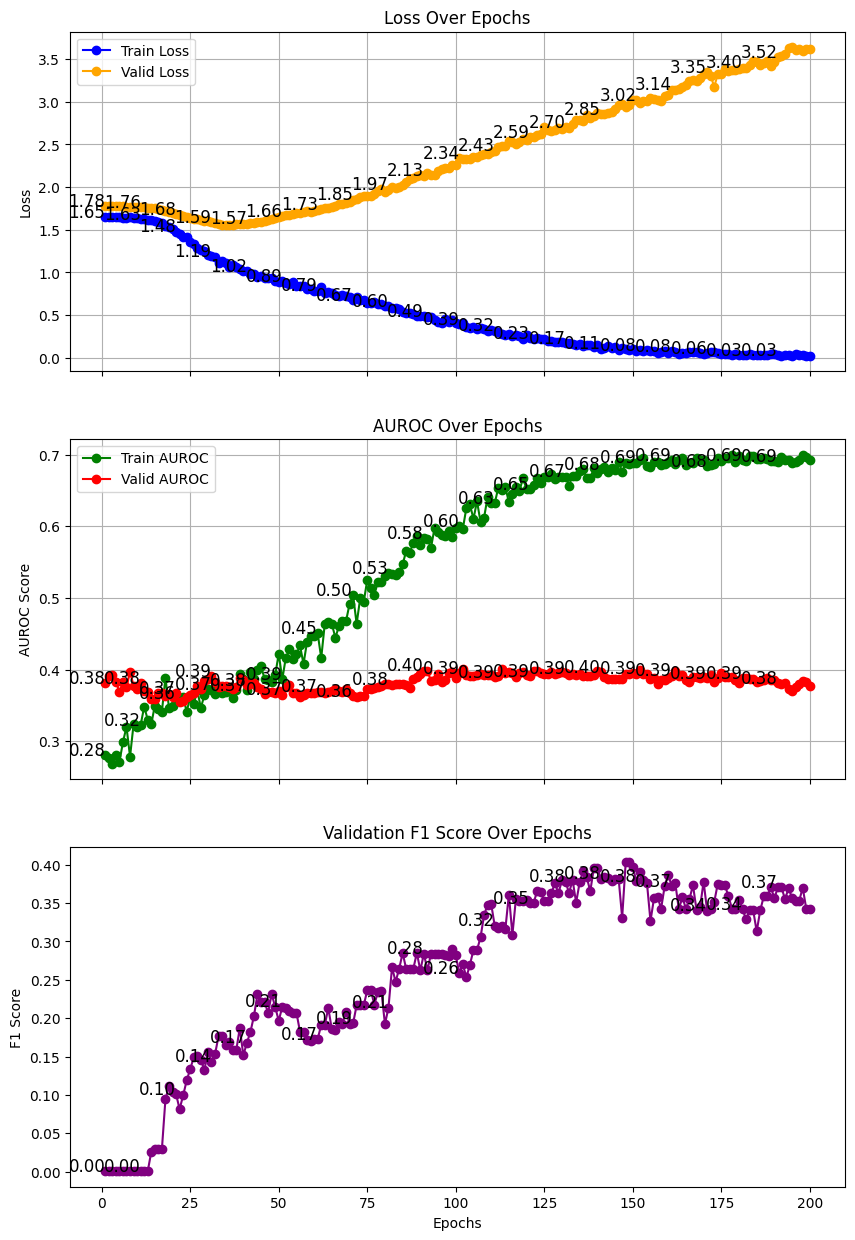

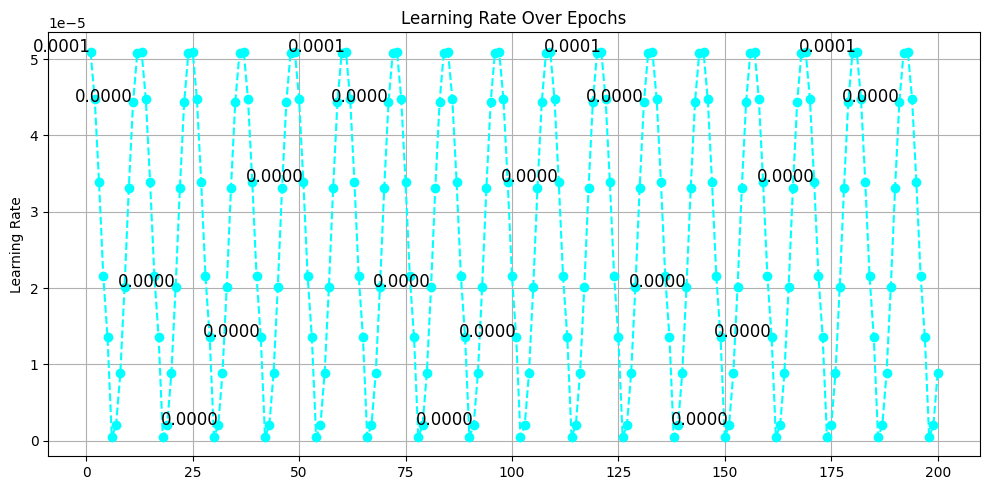

In [ ]:
plot_metrics(history)

In [ ]:
val_epoch_loss, val_epoch_auroc, val_epoch_f1 = valid_one_epoch(model=model, dataloader=validloader, criterion=criterion, 
                                         epoch=1)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=1, Valid_Auroc=0.422, Valid_F1=0.428, Valid_Loss=1.86]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 73.29it/s, Epoch=1, Valid_Auroc=0.394, Valid_F1=0.403, Valid_Loss=2.96]
